In [1]:
import pandas as pd
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/Users/danagajewski/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# DS3000 Final Project: Can r/WSB Predict the Stock Market?

## Team 30
- Darius Sibarium (sibarium.d@northeastern.edu)
- Dana Gajewski (gajewski.d@northeastern.edu)

### Resuse Permissions
The following may be re-used for any purposes:
- all data included with submission
- all images
- this and other jupyter notebooks

# Executive Summary

We built an algorithm that determines the price of any stock based on the past average sentiment of that stock expressed in the r/WSB (Wallstreet Bets) subreddit page. Our model works by scraping all references of a specific stock in r/WSB and performing a sentiment analysis on it, giving it a score between -1 (negative) and 1 (positive). We are then able to sum the sentiment expressed for a given stock on a given day and create up to 5 day running averages of sentiment in r/WSB. Our predicter works by cross validating the average sentiment of 1 through to 5 days of a specific stock as well as the price change relating to the respective day. The predicted price change does a poor job of matching the actual price change. We suggest the model struggles because of possible issues with the sentiment analysis not accurately providing a proper sentiment score. While r/WallStreetBets is a social media chat board, it uses extremely specific language that a generalized sentiment analysis might not properly score. Another drawback is simply the seemingly randomness of the stock market. There are many different features that go into the price changes beyond sentiment of a single subreddit. Trying to predict the stock market with models is an entire branch of finance itself, which interestingly constantly underperforms. 


# Ethical Considerations

We, by any means, are not claiming that one can use our tool to "game" the stock market. There are many models developed by professionals which claim to be able to predict the stock market, ours is not one of those. We suggest this work be used for exploratory purposes only to explore the relationship between social media and the stock market.

In regards to the use of the data from WallStreetBets, Reddit's API is fully open source and available for use. (Honestly, compared to Wall Street there is very little we could do that would be less ethical.) 

# Introduction
Over the last few years, Reddit's r/wallstreetbets (WSB) has been receiving an unbelieabvle amount of attention. Now standing at over 9 million members, the subreddit has been all over the [news](https://www.nytimes.com/2021/01/29/style/gamestop-wallstreetbets-reddit.html) and has become a [threat](https://www.nytimes.com/2021/01/29/technology/stock-traders-reddit-tiktok-youtube.html) to investors and financial professionals. Why? Because they have the power to move markets. **This project aims to determine if and to what extent can r/WSB can predict a stock's price.**

# Data Description
We gathered 2.5 million posts/comments from the r/WSB subreddit page via the [kaggle dataset](https://www.kaggle.com/unanimad/reddit-rwallstreetbets). Then, given a specific stock, we performed a [VADER](https://github.com/cjhutto/vaderSentiment) sentiment analysis, giving a score between 1 (positive) and -1 (negative) for each post. 

In [2]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

bad_sentence = "This is extremely bad!!"
good_sentence = "This is extremely good!!"

sentiment = SentimentIntensityAnalyzer()
sentiment_dict_bad = sentiment.polarity_scores(bad_sentence)
sentiment_dict_good = sentiment.polarity_scores(good_sentence)

print(f'Compound Sentiment for "{bad_sentence}": {sentiment_dict_bad["compound"]}')
print(f'Compound Sentiment for "{good_sentence}": {sentiment_dict_good["compound"]}')

Compound Sentiment for "This is extremely bad!!": -0.6572
Compound Sentiment for "This is extremely good!!": 0.5827


Then, for each specific stock the user requests we did two things:

1. Calculated the 1, 2, 3, 4, 5, and 7 day average sentiment 
2. Using the `YFinance` module, calculated the actual daily change in price of the stock from the day before 

Giving us a final dataset ready for regression analysis:

In [3]:
# Example of analysis of Apple ($AAPL) sentiment in r/WSB
apple_df = pd.read_csv('AAPL_clean.csv', index_col='Unnamed: 0')
apple_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,date written,1 Day Price Change %
0,19.571413,19.592023,19.175799,19.263783,696614800,0.0,0.0,2012-04-11,0.000000
1,19.226866,19.421596,19.088432,19.158264,614336800,0.0,0.0,2012-04-12,-0.547755
2,19.199484,19.217635,18.565767,18.618679,859644800,0.0,0.0,2012-04-13,-2.816461
3,18.767268,18.774036,17.788699,17.846533,1050786800,0.0,0.0,2012-04-16,-4.147159
4,17.809921,18.765418,17.593657,18.756189,1025528000,0.0,0.0,2012-04-17,5.097105


# Method

### Linear Regression

To determine if r/WSB sentiment can predict the price (change) of a stock, we created a multi-feature linear regression model. In essence, every price change will be mapped to a specific sentiment score and a line of best fit will be determined which best fits the data points. The data provided to the model is the data gathered, cleaned, and merged from the previous notebook. The regression will output the linear model as well as the $R^2$ value. The results will then be plotted to help interpret what the model is indicating. 

The reasoning for choosing a linear regression is because the goal of the project is to take a sentiment score and map it to a predicted price change. This lends a hand to linear regression as regression predicts the output value given a series of input values. 

# Results

In [4]:
def clean_datetime(timestamp):
    """ converts UTC time to a datetime object
    Args:
        timestamp (int): UTC time 
    Returns:
        (datetime.datetime): converted UTC time into datetime object
    """
    return datetime.utcfromtimestamp(timestamp).date()

In [5]:
def clean_wsb_df(wsb_df):
    """ cleans raw dataframe of reddit comments
    Args:
        wsb_df (pd.DataFrame): raw dataframe of reddit comments from r/wsb
    
    Returns:
        wsb_df (pd.DataFrame): cleaned dataframe with datetime object as date, no empty rows and no redundant columns
    """

    # converts the utc time to datetime
    wsb_df['date written'] = wsb_df['created_utc'].map(clean_datetime)

    # drop unwanted cols
    wsb_df.drop(columns=['gilded','link_id','id', 'created_utc',
                 'score_hidden', 'name', 'author', 'subreddit_id', 
                 'parent_id', 'author_flair_text', 'author_flair_css_class',
                 'distinguished', 'score_hidden', 'name', 'author', 
                 'subreddit_id', 'parent_id', 'author_flair_text', 
                 'author_flair_css_class','distinguished'], inplace=True)
 
    # Get names of indexes for which body is empty
    bool_empty_body =  wsb_df['body'] == '[deleted]'
    indexNames = wsb_df[bool_empty_body].index

    # Delete these row indexes from dataFrame
    wsb_df.drop(indexNames , inplace=True)
            
    return wsb_df

In [6]:
# DISCLAIMER: can take up to 5 mins to run when called
def get_sentiment(wsb_df):
    """ performs a VADER sentiment analysis on the 'body' of the reddit posts

    Args:
        wsb_df (pd.DataFrame): dataframe of posts from r/wsb

    Returns:
        wsb_df (pd.DataFrame): the inputted dataframe with an additional 'senitment score' column with a number between 0 and 1
    """

    #initializes the sentiment analysis
    sentiment_analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = list()

    #gets the sentiment score of a body of text
    for entry in tqdm(wsb_df['body']): #tqdm shows you progress bar 
        sentiment_score = 0
        try:
            sentiment_score = sentiment_score + sentiment_analyzer.polarity_scores(entry)['compound']
        except:
            sentiment_score = 0
        sentiment_scores.append(sentiment_score)
    
    wsb_df['sentiment score'] = sentiment_scores

    return wsb_df

In [7]:
def filter_wsb(wsb_df, ticker, name):
    """ filters the dataframe to only return rows where the given company is mentioned
    Args:   
        wsb_df (pd.DataFrame): dataframe of r/wsb comments
        ticker (str): ticker symbol of company
        name (str): name of company 

    Returns:
        company_df (pd.DataFrame): dataframe consisting of comments only related to the given company
    """

    #filters the stocks on either ticker or stock name
    company_bool = wsb_df['body'].str.contains(ticker, case=False) | wsb_df['body'].str.contains(name, case=False)
    company_df = wsb_df.loc[company_bool]

    return company_df

In [8]:
def convert_to_datetime(timestamp):
    """ converts a timestamp object to datetime
    
    Args:
        timestamp (pd.Timestamp): pandas timestamp object

    Returns:
        (datettime.datetime): datetime equivalent of the timestamp
    """
    return timestamp.to_pydatetime()

In [9]:
def get_historical_data(ticker, start, end):
    """ gets historical stock market data for the given company between the given time period

    Args:
        ticker (str): the company's ticker symbol
        start (str): the start date (YYYY-MM-DD)
        end (str): the end date

    Returns:
        df_historical (pd.DataFrame): dataframe of historical stock market data for given country and time period
    """
    
    #pulls historical data of a stock from yfinance
    share = yf.Ticker(ticker)
    df_historical = share.history(start=start, end=end)
    df_historical.reset_index(inplace=True)
    df_historical['date written'] = df_historical['Date'].map(convert_to_datetime)
    del df_historical['Date']
    
    #price difference between closing price and last closing price as a percent
    prev_day_up = []
    for index, row in df_historical.iterrows():
        if index == 0:
            prev_day_up.append(0)
        else:
            prev_day_up.append(((row['Close'] - df_historical.iloc[index - 1]['Close']) /
                               df_historical.iloc[index - 1]['Close']) * 100)
            
    df_historical['1 Day Price Change %'] = prev_day_up
    #df_historical.rename(columns= {'Date': 'date written'}, inplace=True)
    return df_historical

In [10]:
def merge_tables(df_wsb, df_stocks):
    """ merges the wsb dataframe with a stock's historical data 

    Args:
        df_wsb (pd.DataFrame): dataframe from r/wsb filtered for a specific stock
        df_stocks (pd.DataFrame): dataframe of a stock's historical performance)

    Returns:
        merged (pd.DataFrame): the two dataframes merged on an outer join on the date column
    """
    # groupby date & sum sentiment score
    df_wsb = df_wsb.groupby('date written')['sentiment score'].sum()
    df_wsb = df_wsb.to_frame()
    df_wsb.reset_index(inplace=True)

    # set create indexes to do join on
    merged = pd.concat([df_wsb.set_index('date written'), df_stocks.set_index('date written')], join='outer', axis=1)

    return merged.dropna()

In [11]:
def get_regression_data(stock_name, ticker, wsb_df):
    """ gets the data of a single stock required for the regression analysis from the wallstreetbets dataframe

    Args:
        stock_name (str): name of the stock
        ticker (str): the stock's ticker symbol (without the $)
        wsb-df (pd.DataFrame): dataframe from r/wsb filtered to only contain comments mentioning stock_name or ticker
        
    Returns:
        df_model_data (DataFrame) the data to be used for regression
    """
    #DATA COLLECTION
    
    #gets the stock and gets the sentiment analysis for each thread
    wsb_stock_df = filter_wsb(wsb_df, ticker, stock_name)
    stock_sentiment_df = get_sentiment(wsb_stock_df)
    
    #gets stock history and merges the two dataframes
    stock_df = get_historical_data(ticker, stock_sentiment_df['date written'].min(), stock_sentiment_df['date written'].max())
    merged = merge_tables(stock_sentiment_df, stock_df)
    merged.reset_index(inplace=True)
    
    model_data_dict = {'price_change' : [], '1_day_sent' : [], '2_day_sent' : [], '3_day_sent' : [], '4_day_sent' : [], 
                  '5_day_sent' : []}
    
    #gets data of each day and historcial sentiment, because saturday and sunday do not have data, 5 days is a week
    for idx, row in tqdm(merged.iterrows()):
        
        #checks that we are not looking for data prior or after what is available
        if idx < 5 or idx >= merged.shape[0] - 1:
            pass
        else:
            model_data_dict['price_change'].append(merged.iloc[idx + 1]['1 Day Price Change %'])
            model_data_dict['1_day_sent'].append(merged.iloc[idx - 1]['sentiment score'])
            model_data_dict['2_day_sent'].append(merged.iloc[idx - 2]['sentiment score'])
            model_data_dict['3_day_sent'].append(merged.iloc[idx - 3]['sentiment score'])
            model_data_dict['4_day_sent'].append(merged.iloc[idx - 4]['sentiment score'])
            model_data_dict['5_day_sent'].append(merged.iloc[idx - 5]['sentiment score'])
            
    #create a dataframe of data for the model
    df_model_data = pd.DataFrame(model_data_dict)
    
    av_sent = []
    
    #add a new column which includes the average of the past week sentiment
    for idx, row in df_model_data.iterrows():
        av_sent.append((row['1_day_sent'] + row['2_day_sent'] + row['3_day_sent'] + row['4_day_sent'] +
                       row['5_day_sent']) / 5)
        
    df_model_data['past_week_sent'] = av_sent
    df_model_data.to_csv('clean.csv')
    return df_model_data

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

def train_model_stock_v1(regression_data):
    """ trains a model that takes in the previous week's sentiment to predict next day price. 
    Note: uses each previous day to try and predict

    Args:
        df_model_data (DataFrame): the data to be used for regression
        
    Returns:
        model_str (str): a string representation of the coefficients of the model 
        r2        (int): the r^2 value of the model
        
    """
    
    x_feat_list = ['1_day_sent', '2_day_sent', '3_day_sent', '4_day_sent', '5_day_sent']
    y_feat = 'price_change'

    n_splits = 10
    
    # get target variable
    x = regression_data.loc[:, x_feat_list].values
    y_true = regression_data.loc[:, y_feat].values

    # initialize a Linear Regression model
    reg = LinearRegression()

    # initialize the kfolds
    kfold = KFold(n_splits=n_splits)

    # initialize an empty array same size as y_true
    y_hat = np.empty_like(y_true)

    for train_idx, test_idx in kfold.split(x, y_true):

        # get training data
        x_train = x[train_idx, :]
        y_true_train = y_true[train_idx]

        # get testing data
        x_test = x[test_idx, :]
        y_true_test = y_true[test_idx]

        # train on training data
        reg.fit(x_train, y_true_train)

        # estimate each penguin's species
        y_hat[test_idx] = reg.predict(x_test)
    
    # print model   
    model_str = y_feat + f' = {reg.intercept_:.2f}'
    for feat, coef in zip(x_feat_list, reg.coef_):
        model_str += f' + {coef:.2f} {feat}'

    # compute r2
    r2 = r2_score(y_true=y_true, y_pred=y_hat)
    
    return model_str, r2
                  

In [13]:
#calulate data - Output file is 453mb, cannot be uploaded or even properly read into Jupyter and
# as such must be generated within the notebook itself
# the above code is taken from the Data and Analysis plan notebook (included in upload)
wsb_df = pd.read_json('Data/wsbData.json', lines=True)
wsb_df_clean = clean_wsb_df(wsb_df)
wsb_df_clean.to_csv('wsb_clean.csv')

In [14]:
#gets the regression data for a selection of stocks
spy_model_data = get_regression_data('SPDR S&P 500 ETF Trust', 'SPY', wsb_df_clean)
aapl_model_data = get_regression_data('Apple', 'AAPL', wsb_df_clean)
msft_model_data = get_regression_data('Microsoft', 'MSFT', wsb_df_clean)
gme_model_data = get_regression_data("Gamestop", "GME", wsb_df_clean)
f_model_data = get_regression_data("Ford", "F", wsb_df_clean)

100%|██████████| 22129/22129 [00:06<00:00, 3250.28it/s]
/Users/danagajewski/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
986it [00:00, 1434.37it/s]
100%|██████████| 28180/28180 [00:13<00:00, 2115.77it/s]
/Users/danagajewski/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
1172it [00:00, 1416.45it/s]
100%|██████████| 12901/12901 [00:04<00:00, 2866.41it/s]
/Users/danagajewski/anaconda3/lib

In [15]:
#generates a model for aapl
model, r2 = train_model_stock_v1(aapl_model_data)
print(model)
print(f'R^2: {r2}')

price_change = 0.11 + -0.03 1_day_sent + 0.03 2_day_sent + -0.01 3_day_sent + -0.02 4_day_sent + 0.01 5_day_sent
R^2: -0.018143692494231534


In [16]:
#generates a model for msft
model, r2 = train_model_stock_v1(msft_model_data)
print(model)
print(f'R^2: {r2}')

price_change = 0.18 + -0.04 1_day_sent + -0.02 2_day_sent + -0.02 3_day_sent + 0.00 4_day_sent + 0.02 5_day_sent
R^2: -0.010190567453822963


In [17]:
#generates a model for gme
model, r2 = train_model_stock_v1(gme_model_data)
print(model)
print(f'R^2: {r2}')

price_change = -0.13 + 0.04 1_day_sent + -0.01 2_day_sent + 0.03 3_day_sent + -0.11 4_day_sent + 0.13 5_day_sent
R^2: -0.010164017397256586


In [18]:
#generates a model for f
model, r2 = train_model_stock_v1(f_model_data)
print(model)
print(f'R^2: {r2}')

price_change = 0.07 + -0.00 1_day_sent + -0.00 2_day_sent + 0.00 3_day_sent + -0.00 4_day_sent + 0.00 5_day_sent
R^2: -4.9900129721835995e-05


In [19]:
#generates a model for spy
model, r2 = train_model_stock_v1(spy_model_data)
print(model)
print(f'R^2: {r2}')

price_change = 0.08 + -0.00 1_day_sent + 0.02 2_day_sent + -0.01 3_day_sent + -0.02 4_day_sent + -0.01 5_day_sent
R^2: -0.002331615790590158


### Brief Analysis 1

With an average $R^2$ of right around 0, it is clear that this model is not effective at predicting the change in price using the sentiment of the past 5 trading days as individual features. It is possible that the change of each day is ineffective and using the average sentiment from the past 5 trading days would provide a better model. To test this, we will create a second model that uses the average sentiment to try and predict the next day price change. 

What is interesting is that the sentiment coefficients tend to be negative, indicating that the more positive the sentiment score for a stock, the more a stocks price will decrease. This is quite opposite of what would be expected. 

In [20]:
def train_model_stock_v2(regression_data):
    """ trains a model that takes in the previous week's sentiment to predict next day price. 
    Note: Uses average of past week sentiment

    Args:
        df_model_data (DataFrame): the data to be used for regression
        
    Returns:
        model_str (str): a string representation of the coefficients of the model 
        r2        (int): the r^2 value of the model
        
    """
    
    x_feat_list = 'past_week_sent'
    y_feat = 'price_change'
    
    n_splits = 10
    
    # get target variable
    x = (regression_data.loc[:, x_feat_list].values).reshape(-1, 1)
    y_true = regression_data.loc[:, y_feat].values

    # initialize a Linear Regression model
    reg = LinearRegression()

    # initialize the kfolds
    kfold = KFold(n_splits=n_splits)

    # initialize an empty array same size as y_true
    y_hat = np.empty_like(y_true)

    for train_idx, test_idx in kfold.split(x, y_true):

        # get training data
        x_train = x[train_idx]
        y_true_train = y_true[train_idx]

        # get testing data
        x_test = x[test_idx]
        y_true_test = y_true[test_idx]

        # train on training data
        reg.fit(x_train, y_true_train)

        # estimate each penguin's species
        y_hat[test_idx] = reg.predict(x_test)
    
    # print model   
    model_str = y_feat + f' = {reg.intercept_:.2f}'
    for feat, coef in zip(x_feat_list, reg.coef_):
        model_str += f' + {coef:.2f} {feat}'
        
    # compute r2
    r2 = r2_score(y_true=y_true, y_pred=y_hat)
    
    return model_str, r2

In [21]:
#generates a model for aapl
model, r2 = train_model_stock_v2(aapl_model_data)
print(model)
print(f'R^2: {r2}')

price_change = 0.10 + -0.00 p
R^2: -0.0021373250873477634


In [22]:
#generates a model for msft
model, r2 = train_model_stock_v2(msft_model_data)
print(model)
print(f'R^2: {r2}')

price_change = 0.18 + -0.06 p
R^2: -0.0038906131168123803


In [23]:
#generates a model for gme
model, r2 = train_model_stock_v2(gme_model_data)
print(model)
print(f'R^2: {r2}')

price_change = -0.13 + 0.07 p
R^2: -0.005586796137660777


In [24]:
#generates a model for f
model, r2 = train_model_stock_v2(f_model_data)
print(model)
print(f'R^2: {r2}')

price_change = 0.07 + -0.00 p
R^2: 0.0008170229034997201


In [25]:
#generates a model for spy
model, r2 = train_model_stock_v2(spy_model_data)
print(model)
print(f'R^2: {r2}')

price_change = 0.08 + -0.02 p
R^2: -0.0025683403252669823


### Brief Analysis 2

The new $R^2$ values appear to be slightly closer to 0 and are less negative, however because they are still negative, the model clearly is not sufficient to predict the price change the next day. It would appear that it doesn't really matter how the data is being regressed, there is very little correlation in the data between the sentiment score and the price change on the next day. This can be seen by the fact that all of the coefficients are all right around 0. This means that there is almost no change resulting from a change in sentiment. This can be interpreted as meaning that the sentiment score calculated has no impact on the price change of the next day. This is very similar to the multi-variate regression, where the coefficients were also close to 0.

Similar to the multi-variate regression, the coefficients tend to be negative indicating an inverse relationship of sentiment score and price change. However, based on slightly better $R^2$ values, we will assume this is the better model. 

## Testing on a Subset of the S&P 500

Up until this point, the regression model has only been trained on a single stock, however this is not really an accurate measure if the model works on the whole. A good way to test if the model works or not on the whole market is to run the model on a group of stocks. We picked the S&P 500 as it is one of the most common indices used to measure the market. To decrease runtimes, only the top 10 stocks in the SPY ETF were used as a representative sample. Otherwise runtimes for all 500 are near 2 hours. 

Fun fact, there are actually 505 common stocks in the S&P 500, not 500 per the [Wikipedia](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies). This is because there are 500 companies, but 5 of them offer more than 1 stock, ex. GOOG and GOOGL both representing Alphabet. 

In [26]:
#list of top 10 securities in SPY ETF. SPY is a S&P 500 tracking ETF. 
spy_top_tickers = ['AAPL', 'MSFT', 'AMZN', 'FB', 'BRK-B', 'GOOGL', 'GOOG', 'TSLA', 'JNJ', 'JPM']
spy_top_names = ['Apple', 'Microsoft', 'Amazon', 'Facebook', 'Berkshire Hathaway', 'Alphabet Class A',
                   'Alphabet Class C', 'Tesla', 'Johnson & Johnson', 'JPMorgan Chase']

#zipping tickers and names into pairs
zipped = zip(spy_top_tickers, spy_top_names)

In [27]:
#the eventual culmination dataframe of all data. 
spy_data = pd.DataFrame()

#get the regression data for the selected stocks above
for ticker, name in zipped:
    new_data = get_regression_data(name, ticker, wsb_df_clean)
    spy_data = pd.concat([spy_data, new_data])

spy_data.reset_index(inplace=True)
spy_data.tail()

100%|██████████| 28180/28180 [00:13<00:00, 2024.07it/s]
/Users/danagajewski/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
1172it [00:00, 1300.82it/s]
100%|██████████| 12901/12901 [00:05<00:00, 2523.23it/s]
/Users/danagajewski/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
743it [00:00, 1163.66it/s]
100%|██████████| 28547/28547 [00:12<00:00, 2225.89it/s]
/Users/danagajewski/anaconda3/lib

,index,price_change,1_day_sent,2_day_sent,3_day_sent,4_day_sent,5_day_sent,past_week_sent
7933,440,-1.862219,-0.1888,0.7351,0.2732,0.2023,-1.2452,-0.04468
7934,441,1.519987,1.1615,-0.1888,0.7351,0.2732,0.2023,0.43666
7935,442,-1.373277,0.5684,1.1615,-0.1888,0.7351,0.2732,0.50988
7936,443,1.382726,0.0000,0.5684,1.1615,-0.1888,0.7351,0.45524
7937,444,1.764431,0.0000,0.0000,0.5684,1.1615,-0.1888,0.30822


In [28]:
#generates a model for the top 10 spy stocks with average of the previous 5 days sentiment
model, r2 = train_model_stock_v2(spy_data)
print(model)
print(f'R^2: {r2}')

price_change = 0.14 + -0.02 p
R^2: 0.0004450226853829342


### Brief Analysis 3

The model appears to do just slightly better when it is trained on several stocks at once, however the model is still not explaining any of the variation of the data, and is certainly not statistically significant. Possibly by increasing the datapoints, we get closer to the average and as such the model is essentially guessing the mean price change. This can be clearly seen in the mutli-variate model, where 4 out of 5 of the coefficients are 0 indicating that the model is essentially guessing the y-intercept which represents the mean price change.

## Visualization

To help better understand what the results are indicating, below are visualizations that scatter the data and overlays the predicted line. 

In [29]:
def plot_regression_data(regression_data, ticker):
    ''' Plots the data of the model generated from our prefered model, the average sentiment score model
        on the data collected. 
        
    Args:
        regression_data (DataFrame): the data being regressed
        ticker                (str): the ticker of the stock being plotted
    '''
    x_feat_list = 'past_week_sent'
    y_feat = 'price_change'

    n_splits = 10

    # get target variable
    x = (regression_data.loc[:, x_feat_list].values).reshape(-1, 1)
    y_true = regression_data.loc[:, y_feat].values

    reg = LinearRegression()
    reg.fit(x, y_true)
    y_pred = reg.predict(x)
    
    # initialize the kfolds
    kfold = KFold(n_splits=n_splits)

    # initialize an empty array same size as y_true
    y_hat = np.empty_like(y_true)

    for train_idx, test_idx in kfold.split(x, y_true):

        # get training data
        x_train = x[train_idx]
        y_true_train = y_true[train_idx]

        # get testing data
        x_test = x[test_idx]
        y_true_test = y_true[test_idx]

        # train on training data
        reg.fit(x_train, y_true_train)

        # estimate each penguin's species
        y_hat[test_idx] = reg.predict(x_test)
    
    
    r2 = r2_score(y_true=y_true, y_pred=y_hat)
    
    #scatters the data
    plt.scatter(x, y_true, alpha=.2, color='b', label='Actual data')
    
    #plots the model
    plt.plot(x, y_pred, color='r', label='prediction')
    
    #formats the graphs
    plt.legend()
    plt.xlabel("Past Week's Sentiment")
    plt.ylabel("% Closing Price Change")
    plt.suptitle('{} 7-day Average r/WSB Sentiment vs % Change in Stock Price. R^2: {:.4f}'.format(ticker, r2))
    plt.gcf().set_size_inches(10, 6)
    
    #saves the graphs
    plt.savefig(f"{ticker}_wsb_model_scatter.pdf")

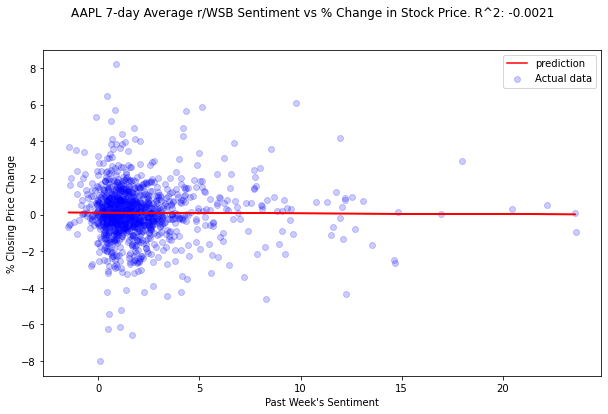

In [30]:
plot_regression_data(aapl_model_data, "AAPL")

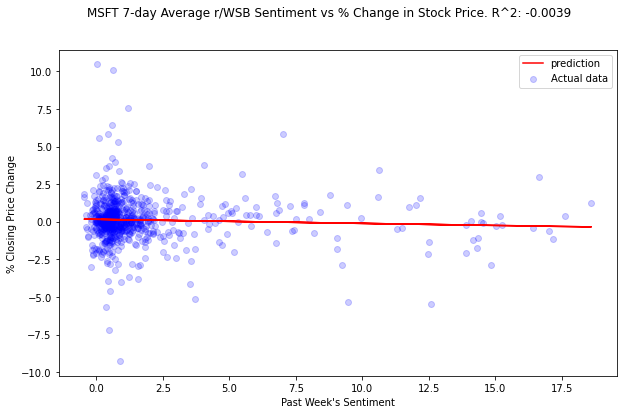

In [31]:
plot_regression_data(msft_model_data, "MSFT")

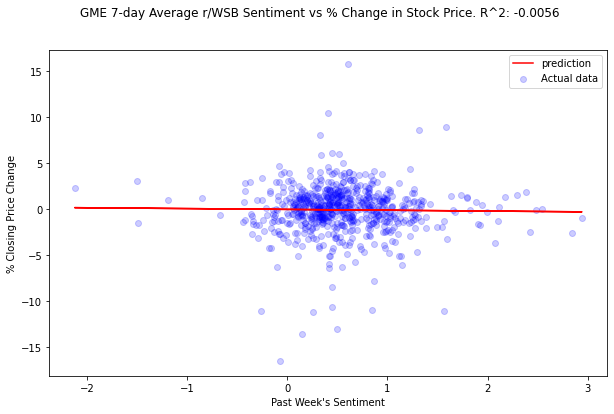

In [32]:
plot_regression_data(gme_model_data, 'GME')

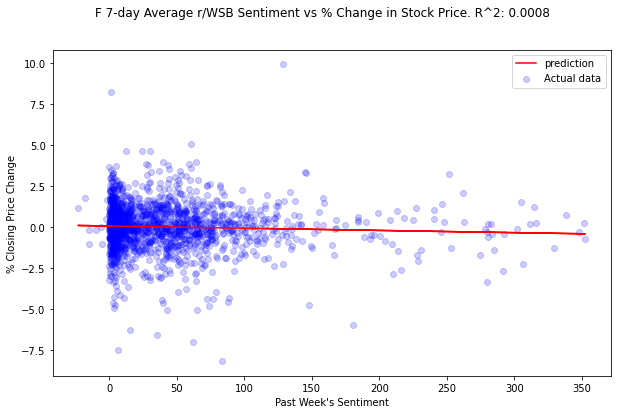

In [33]:
plot_regression_data(f_model_data, 'F')

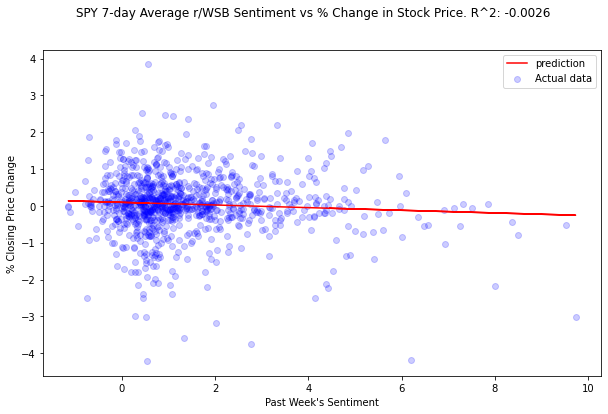

In [34]:
plot_regression_data(spy_model_data, 'SPY')

What we glean from these visualizations is that the data appears to not have a clear trend, and the sentiment score does not seem to have any correlation with the price changes. It appears to be quite random and would suggest why our models were unable to predict the price change. 

In [35]:
#rezipping tickers and names of top 10 SPY stocks into pairs
zipped = zip(spy_top_tickers, spy_top_names)

In [36]:
r2_list = []
tickers = []

#get the model and r2 values= for every stock in the S&P 500.
for ticker, name in zipped:
    new_data = get_regression_data(name, ticker, wsb_df_clean)
    model, r2 = train_model_stock_v2(new_data)
    r2_list.append(r2)
    tickers.append(ticker)
    

100%|██████████| 28180/28180 [00:15<00:00, 1837.10it/s]
/Users/danagajewski/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
1172it [00:00, 1229.92it/s]
100%|██████████| 12901/12901 [00:05<00:00, 2285.73it/s]
/Users/danagajewski/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
743it [00:00, 1236.67it/s]
100%|██████████| 28547/28547 [00:16<00:00, 1774.39it/s]
/Users/danagajewski/anaconda3/lib

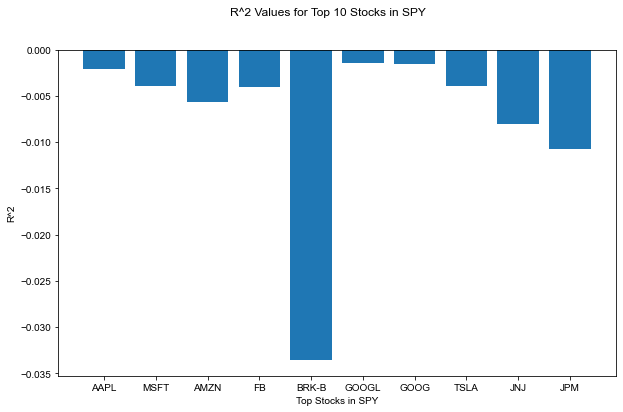

In [37]:
#generates a bargraph showing the R^2 values for the 10 different stocks. 
plt.bar(tickers, r2_list)

#formats the plot
plt.xlabel("Top Stocks in SPY")
plt.ylabel("R^2")
plt.suptitle('R^2 Values for Top 10 Stocks in SPY')
plt.gcf().set_size_inches(10, 6)
sns.set()
plt.savefig("spy_top10_r^2_bar.pdf")

# Discussion

The project did not succeed at predicting the stock market based on r/WSB sentiment at all (cross-validated $r^2$ < 0 for every stock). Because the coefficients of the regressions were so close to 0, what our models were doing was predicing the mean price change. This is not predicting at all and is simply guessing. In fact, with $R^2$ values that dip below 0, the models are doing worse than predicting the mean value. It is fair to say that our model does not work, which is to say that in the context of our project, **r/WallStreetBets does not drive stock market prices. **

This can be due to many reasons:

1. First and foremost, the stock market is incredibly difficult to predict. Using models to do so is its own branch of finance known as "Quantitative Finance" and is a multi-billion dollar segment of the industry. It also is constantly one of the bottom performing strategies at investment firms. (I, Dana, co-oped with Wellington Management and worked with all different strategies. The bottom performing ones were consistently the quantitative modeling strategies.) If our model had worked, then we would have done something that a several trillion dollar industry filled with multitudes of PHD researchers are unable to do. Therefore, while disheartening, it makes these results not unexpected.

2. We only ran our model on a few stocks at a time at the most. This was to prevent enormous runtimes, but smaller sample sizes definitely prevents accurate results. With over 2,800 companies in the US stock market, it is entirely possible that our model is able to work for a specific publically traded US company however it would take roughly 3.8 days of constant running for our model to test every stock.

3. Our day change in stock price is based on the **closing** price. It is possible that the sentiment may have a greater effect on the opening price.

4. We only used one sentiment anaylsis tool, maybe different results with different sentiment analyses would provide more accurate sentiment scores. The tool we did use very rarely generated a negative comment, demonstrating that it is likely the anlysis was confusing sentiment. A sentiment analysis specifically for r/WSB that specifically takes into account the linguistics used and updates itself constantly to keep in touch with the current trends would allow for a more accurate sentiment score and perhaps more accurate results. Examples of the specific language that could have been missed includes use of slurs in a positive manner, emojis to indicate sentiment that wouldn’t normally indicate a sentiment like 🐻 is generally negative, and 🚀  is very good.

5. The dataset we used for r/WSB was from 2012 (the inception of the subreddit) to 2018. r/WSB gained traction mostly during the 2021 GME short squeeze, so the number of users was drastically smaller at the time of our dataset (shown below). This certainly limited the validity of our conclusion, as the results would likely be different with a dataset of this year.

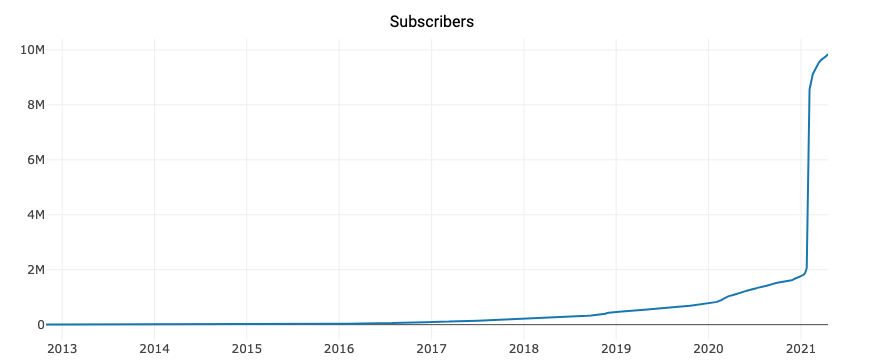

6. The reason why it may look like r/WSB is moving markets is because the news places emphasis on it. It makes for an interesting headline, but does not completely convey the truth. This is what could have led us to assume that there may have been a correlation in the first place. 

Given all of these limitations, it makes it hard to fully accept the results of this project. Given more resources, better sentiment analysis, and more time, there is potential to achieve a result that disputes ours. 

# Takeaways

Unfortunately, there is no free money for us here. Because of the inability of our model to predict the price changes of the markets, it better serves as an example of the difficulty in predicting the stock markets. That isn't to say it is impossible. With more time and perhaps funding, there are certainly some action items that could be taken to possibly create a better model that would better predict price changes. 

1. The first major change that would improve this model is, as mentioned before, a better sentiment analysis. The specific language of r/WallStreetBets is highly complex and it is very unlikely that a social media sentiment analysis would be able to pick up on the constantly adapting language used. A solution would be to train a sentiment analysis specifically for r/WallStreetBets. We are unsure of how to develop a sentiment analysis and thus were unable to do it for this project, however a team with the resources to do so would certainly be able to generate better sentiment score. The sentiment analysis would also need to constantly update itself to keep up to date with the memes and linguistic oddities that develop constantly. 

2. We locked in our model to look solely at the past 5 trading days for sentiment and the next day to predict price. This limited our model, and perhaps was not the right intervals to be looking at. Through much trial and error, it may be possible that a different set of dates would provide one with a more accurate estimate. For example, perhaps averaging the past 2 weeks sentiment to predict the next week's average price change would have been more accurate. 

On the whole, there certainly is merit to the idea that stocks price change is tied to investor sentiment, as that is what drives prices in the most stripped down sense, however looking purely at Wall Street Bets with a broad sentiment analysis may not provide enough clarity to truly measure the sentiment of the investors driving the markets.

# Citations

Citation: Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.